###코드 목표

목표 : 이미지에서 얼굴 이미지를 찾아서, key point들을 찾은 후, 코 위치에 고양이 수염을 달아줌

방식
1. open-cv를 이용하여 이미지 로드
2. dlib 라이브러리 사용 : 이미지의 HOG (Histogram of Oriented Gradients) 를 찾음 -> 얼굴을 찾아 bound box 생성
3. pretrained 모델 + dlib 라이브러리 사용 : bound box 내의 특징점 (key point)들을 찾아서 표시
4. 얼굴에 붙힐 이미지를 원하는 좌표에 attach

하면서 추가하기

In [125]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

In [139]:
# 필요한 파일 불러오기

# pretrained 얼굴 랜드마크 모델 불러오기
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

# 얼굴 이미지 파일 불러오기
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img_bgr = cv2.imread(img_path)
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # openCV가 이미지를 불러올때는 BGR로 받아오기 때문에, RGB로 변환
        if img is not None:
            images.append(img)
    return images

# 이미지 파일 경로
my_image_path = './images/face/'
attach_img = cv2.imread('./images/cat-whiskers.png')

fc_imgs_rgb = load_images_from_folder(my_image_path)
img_save = fc_imgs_rgb.copy()      # 출력용 이미지를 따로 보관합니다
# print(fc_imgs_rgb)

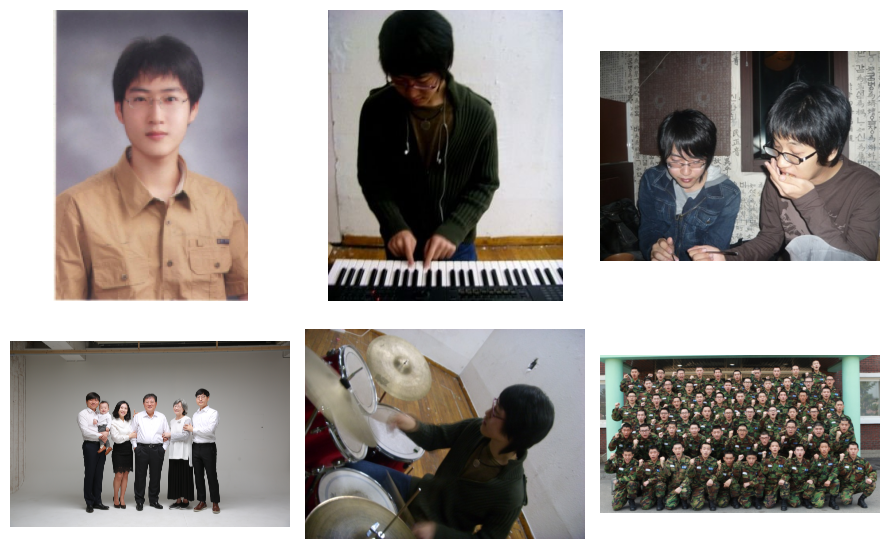

In [127]:
# 이미지들 시각화
def plot_images(images, cols=5):
    rows = len(images) // cols + (1 if len(images) % cols != 0 else 0)
    plt.figure(figsize=(9, 3 * rows))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(fc_imgs_rgb, cols=3)

In [128]:
# 이미지에서 HOG (Histogram of Oriented Gradients) 특징 추출하는 함수
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# 찾은 얼굴 영역 박스 리스트
dlib_rects = []
for img in fc_imgs_rgb: 
    dlib_rects.append(detector_hog(img, 3))   # (image, num of image pyramid)

print(dlib_rects)   

[rectangles[[(46, 53) (102, 109)]], rectangles[], rectangles[], rectangles[[(2761, 1218) (3001, 1458)], [(2234, 1348) (2434, 1547)], [(3800, 1112) (4039, 1351)], [(1843, 1345) (2009, 1511)], [(3344, 1326) (3543, 1525)], [(1635, 1192) (1835, 1392)]], rectangles[], rectangles[[(917, 195) (956, 234)], [(249, 488) (296, 534)], [(523, 276) (569, 323)], [(964, 281) (1003, 320)], [(750, 519) (796, 565)], [(950, 356) (1006, 412)], [(1020, 200) (1059, 238)], [(1137, 178) (1183, 225)], [(373, 467) (420, 514)], [(938, 127) (977, 165)], [(874, 452) (920, 498)], [(582, 79) (620, 118)], [(110, 374) (157, 421)], [(517, 468) (572, 524)], [(301, 286) (348, 333)], [(115, 503) (162, 550)], [(998, 477) (1044, 524)], [(887, 71) (926, 109)], [(342, 359) (389, 405)], [(1092, 363) (1148, 418)], [(1271, 467) (1318, 514)], [(1127, 457) (1173, 503)], [(156, 79) (195, 118)], [(575, 385) (621, 431)], [(1222, 344) (1278, 400)], [(745, 281) (791, 328)], [(371, 230) (410, 269)], [(704, 374) (750, 421)], [(1076, 281) 

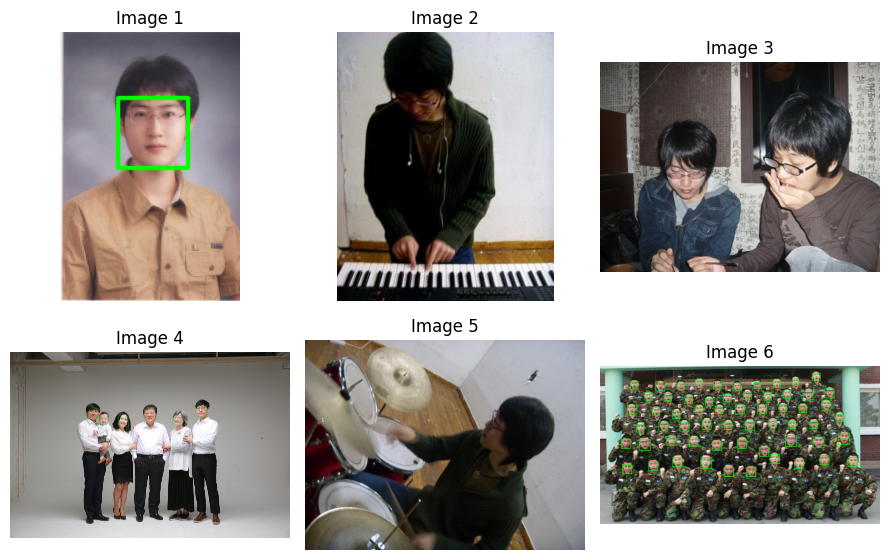

In [129]:
# 각 이미지의 얼굴 영역에 바운딩 박스를 그리는 코드
for img_idx, img in enumerate(fc_imgs_rgb):
    for dlib_rect in dlib_rects[img_idx]: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv2.rectangle(img, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

# 시각화 설정
cols = 3  # 열의 수
rows = len(fc_imgs_rgb) // cols + (1 if len(fc_imgs_rgb) % cols != 0 else 0)

plt.figure(figsize=(9, 3 * rows))

# 각 이미지를 서브플롯에 배치
for i in range(len(fc_imgs_rgb)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fc_imgs_rgb[i])
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

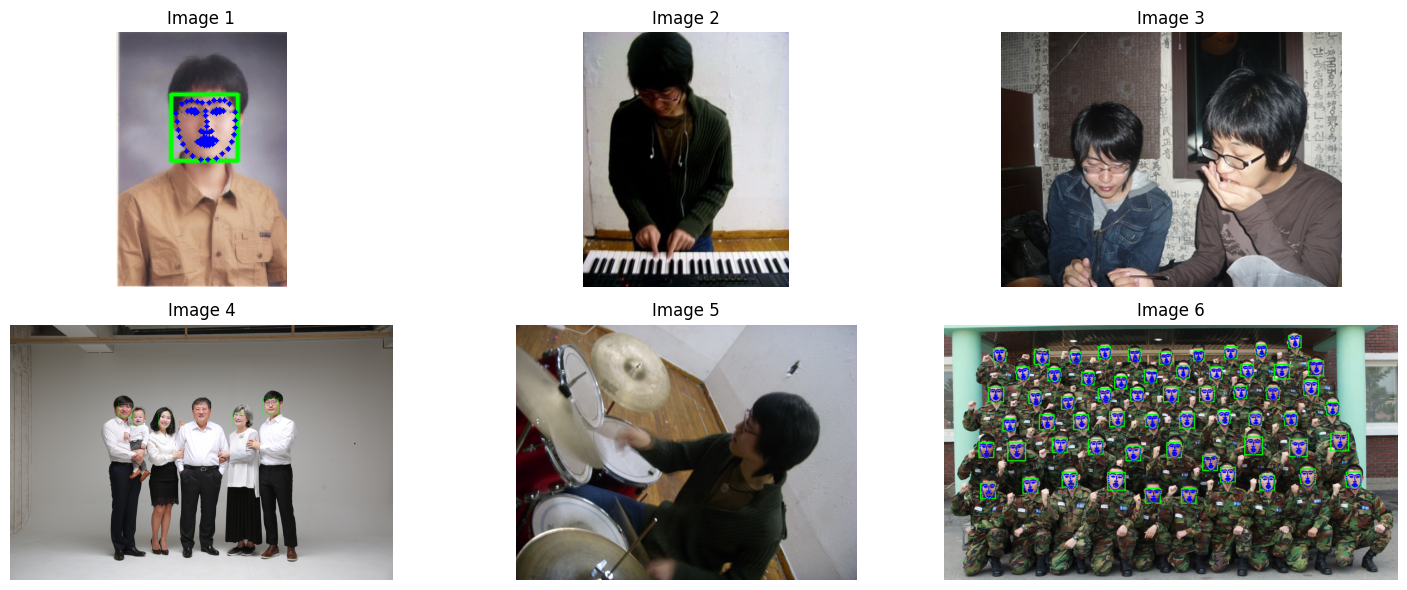

In [130]:
# 랜드마크의 위치를 저장할 리스트 생성
list_landmarks = []

# 얼굴 영역 박스마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for img_idx, img in enumerate(fc_imgs_rgb):
    landmarks = []
    for dlib_rect in dlib_rects[img_idx]:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        landmarks.append(list_points)
    list_landmarks.append(landmarks)

# 각 이미지의 얼굴 영역에 바운딩 박스와 랜드마크 그리기
for img_idx, img in enumerate(fc_imgs_rgb):
    for dlib_rect in dlib_rects[img_idx]: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv2.rectangle(img, (l, t), (r, b), (0, 255, 0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

    # 랜드마크 그리기
    for landmark in list_landmarks[img_idx]:
        for point in landmark:
            cv2.circle(img, point, 2, (0, 0, 255), -1)

# 시각화 설정
cols = 3  # 열의 수
rows = len(fc_imgs_rgb) // cols + (1 if len(fc_imgs_rgb) % cols != 0 else 0)

plt.figure(figsize=(15, 3 * rows))

# 각 이미지를 서브플롯에 배치
for i in range(len(fc_imgs_rgb)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(fc_imgs_rgb[i])
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

img_show = img_save.copy()

# 코의 좌표와 관련된 정보 출력
for dlib_rect, landmarks, img in zip(dlib_rects, list_landmarks, img_show):
    if landmarks:  # 빈 리스트가 아닌 경우에만 실행
        for landmark in landmarks:
            nose_point = landmark[30] # 코의 index는 30 입니다
            x = nose_point[0] # 이미지에서 코 부위의 x값
            y = nose_point[1] - dlib_rect[0].height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수 // 2
            w = h = dlib_rect[0].width() # 얼굴 영역의 가로를 차지하는 픽셀의 수

            # print(f'코의 좌표: (x, y) = ({x}, {y})')
            # print(f'얼굴 영역의 크기: (w, h) = ({w}, {h})')

            img_sticker = cv2.resize(attach_img, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
            
            refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
            refined_y = y  # 89-187 = -98
            
            # # 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
            if refined_x < 0: 
                img_sticker = img_sticker[:, -refined_x:]
                refined_x = 0
            # 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
            if refined_y < 0:
                img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
                refined_y = 0
            # print (f'(x,y) : ({refined_x},{refined_y})')

            sticker_area = img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
            
            img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
            np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

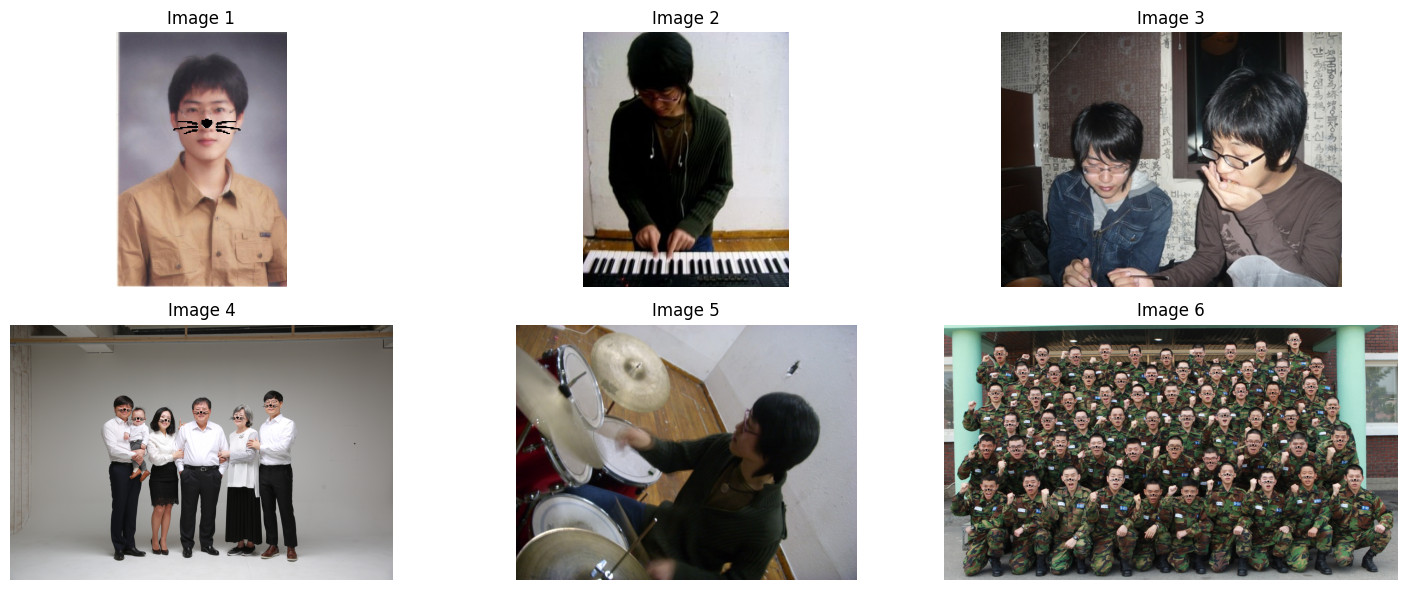

In [141]:
# 시각화 설정
cols = 3  # 열의 수
rows = len(img_show) // cols + (1 if len(img_show) % cols != 0 else 0)

plt.figure(figsize=(15, 3 * rows))

# 각 이미지를 서브플롯에 배치
for i in range(len(img_show)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_show[i])
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### 회고

배운 점 : 이론만 알고 있던 face recognition을 이해할 수 있어서 좋았음, 정면을 보는 것만 잘 인식하는 것은 (추가 학습이 되지 않은) 모델의 한계라고 CV 전공자분이 얘기해주셨음, image pyramid 수를 3으로 눌리니 작은 얼굴들도 다 인식이 잘 되서 신기했다

아쉬운 점 : 환경 세팅에 시간이 오래 걸려서 조금 늦게 시작했다

느낀 점 : 코딩은 생각보다 어렵구만..

어려웠던 점 : 스티커 좌표 조정이 잘 되지 않았음